# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Оглавление:
I. [Открытие данных](#start)
   * [Первые выводы](#first_conclusions)
   * [Изучим пропуски  высоты потолков и посмотрим, от чего они могут зависеть](#empty_ceils)
   * [Вывод по пропускам в столбце ceiling_height](#ceiling_height_conclutions)
   * [Изучим пропуски в столбце с жилой площадью и посмотрим, зависят ли они от типов жилья: апартаменты и студия](#empty_livivng_area)
   * [Вывод по пропускам в столбце living_area](#living_area_conclusions)
   * [Изучим пропуски в столбце с площадью кухни и посмотрим, зависят ли они от типов жилья: апартаменты и студия](#empty_kitchen_area)
   * [Вывод по пропускам в столбце kitchen_area](#kitchen_area_conclusions)
   * [Внимательнее посмотрим на пропуски в столбцах](#empty_many_cols")
   * [Вывод по пропускам в столбцах: airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000 ](#strange_conclusions)
   
II.[Предобработка данных](#data_pre-processing)
   * [Заменим тип первой даты размещения объявления  со строкового на 'date'](#date)
   * [Заменяем пропуски на нули в `is_apartment`, присваиваем столбцу тип bool](#bool)
   * [Заменяем пропуски в `balcony`, чтобы потом не путаться и знать, что у этих квартир просто нет балконов](#balcony)
   * [Удалим из нашей выборки объявление, где нет населенных пунктов](#no_flats)
   * [Попробуем заменить пропуски высоты потолков](#no_ciels)
   * [Вывод по потолкам № 1](#ciels_conclutions)
   * [Вывод по потолкам № 2](#ciels_conclutions_2)
   
III.[Добавление в таблицу необходимых солбцов](#new_cols)
   * [Посчитаем и добавим цену квадратного метра](#new_col_m2)
   * [Добавим три столбца: день недели, месяц и год публикации объявления](#new_3_col)
   * [Добавим в таблицу столбец "Этаж" с категориальными значениями: первый, последний, другой](#floors_cat)
   * [Добавим соотношение жилой и общей площади, а также отношение площади кухни к общей](#livivng_total_area)
   
IV. [Проведем исследовательский анализ данных](#exploratory_analysis)
  * [Исследуем параметры: площадь, цена, число комнат, высота потолков](#s_price_rooms_ceils)
   * [Вывод по площади](#s_conc)    
   * [Вывод по цене](#price_conc)
   * [Вывод по количеству комнат](#count_rooms_conc)
   * [Вывод по высоте потолков](#ceils_conc)
   * [Изучим время продажи квартиры](#t_sold_flats)    
   * [Вывод по времени продажи квартиры](#con_t_sold_flats)
   * [Уберем редкие и выбивающиеся значения из выборки](#one_offs)
   * [Разберемся, какие факторы больше всего влияют на стоимость квартиры](#factors_price)
   * [Вывод по зависимости  цены от площади](#area_price)
   * [Вывод по зависимости цены от количества комнат](#room_price)
   * [Вывод по зависимости цен от удаленности от центра](#center_price)
   * [Вывод по зависимости цены от категории этажа (первый, последний, другой)](#flat_price)
   * [Вывод по зависимости цены от дня/месяца/года подачи объявления](#date_d_m_y_price)
   * [Выберем 10 населённых пунктов с наибольшим числом объявлений и проведем по ним анализ](#1oc_top_10)
   * [Вывод по зависимости цены от населенного пунтка ( Топ 10)](#conclusions_loc_top_10)
   * [Изучим внимательнее предложения квартир в разрезе удаленности от центра Санкт-Петербурга](#flats_spb)
   * [Вывод по зависимости цены квартиры в СПб от удаленности от центра](#conclusions_spb)
   * [Изучим сегмент квартир в центре](#center_flats_res)
   * [Вывод по зависимости цены от площади в СПб](#conc_centet_flats_res)
   * [Вывод по зависимости цены от количества комнат](#conc_centet_flats_res_rooms)
   * [Вывод по зависимости цены от категории этажа (первый, последний, другой)](#conc_centet_flats_res_floor)
   * [Вывод по зависимости цены от дня/месяца/года подачи объявления](#conc_centet_flats_res_data_d_m_y)
   
V. [Общий вывод](#total_conculution)

### I. Открытие данных  <a id="start"></a>

In [6]:
import pandas as pd
from io import BytesIO
import requests
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)

In [7]:
def data_from_g_sheets(spreadsheet_id):
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    return pd.read_csv(BytesIO(r.content))

In [8]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = data_from_g_sheets('1IDTxFr8-uDnRsV9q8aWvh0eIlQ35wA_zJBBuAwsra-I')

In [9]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20999,20,4290000.0,38.0,2018-11-20T00:00:00,1,NaN,16.0,13.0,1,NaN,False,False,16.00,NaN,Санкт-Петербург,21413.0,23125.0,0.0,NaN,2.0,228.0,112.0
18046,12,10000000.0,66.5,2017-09-10T00:00:00,2,NaN,4.0,34.0,2,NaN,False,False,11.60,NaN,Санкт-Петербург,24688.0,4907.0,0.0,NaN,0.0,NaN,270.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,NaN,False,False,8.34,NaN,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
12081,10,5300000.0,51.0,2018-11-02T00:00:00,2,NaN,21.0,26.0,10,NaN,False,False,8.70,NaN,Санкт-Петербург,22077.0,17405.0,0.0,NaN,1.0,274.0,67.0
20496,5,4050000.0,64.1,2017-07-11T00:00:00,3,2.50,9.0,46.2,2,NaN,False,False,6.10,2.0,Ломоносов,46599.0,50023.0,0.0,NaN,1.0,553.0,464.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [11]:
df.isna().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

#### Первые выводы: <a id="first_conclusions"></a>
 1. Смущает большое кол-во пропусков 39% в столбце `ceiling_height`. Нужно понять, с чем это связно, и  есть ли кореляция высоты потолков с  какими-либо другими данными из таблицы, чтобы попробвать заполнить пропуски. Нам эти данные нужны для исследований.
 2. Нужно понять, почему пропущены данные в столбце `living_area`, и есть ли связь с типом жилья. Может быть есть связь с типами жилья студия или апартаменты. Нужно выяснить.
 3. Аналогичная ситуация с `kitchen_area`. Возможно, аналгоично, есть связь с типом жилья из столбца `studio` или `is_apartment`
 4. Интересным выглядит одинаковое кол-во пропусков в столбцах: `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000`.
 5. В столбцах  `parks_nearest`  и `ponds_nearest` по ~60% пропусков. С этими данными мы, скорее всего, ничего делать не будем. Предположим, что рядом с этими квартирами нет парков и прудов.
 6. В `days_exposition` тоже есть пропуски. Я думаю, что на период выгрузки эти квартиры были все еще в продаже, и объявлние не снимали. 
 7. Есть незначительное количество пропусков в столбце `loclality_name`. Нам очень важен этот столбец, но придумывать населенные пункты для этих квартир бессмысленно. Думаю, что мы избавимся от этих объявлений в исследовании.

 Будем разбираться...


#### Изучим сами данные по каждому столбцу, чтобы понять, где могут скрываться аномальные значения

In [12]:
display(df.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


#### 1.1. Изучим пропуски  высоты потолков и посмотрим, от чего они могут зависеть <a id="empty_ceils"></a>

In [13]:
display(df[df['ceiling_height'].isna()].sample(30))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5214,13,5190000.0,63.0,2017-06-23T00:00:00,3,NaN,9.0,42.10,2,NaN,False,False,8.30,NaN,Санкт-Петербург,42270.0,9229.0,0.0,NaN,0.0,NaN,154.0
17597,15,5790000.0,84.1,2018-03-06T00:00:00,3,NaN,6.0,41.50,1,False,False,False,10.20,NaN,Санкт-Петербург,26721.0,5569.0,1.0,447.0,1.0,585.0,95.0
17599,8,3400000.0,42.0,2017-11-29T00:00:00,3,NaN,5.0,31.00,3,NaN,False,False,6.00,NaN,Санкт-Петербург,12686.0,12295.0,2.0,353.0,1.0,651.0,41.0
15962,11,1000000.0,58.0,2018-08-09T00:00:00,3,NaN,5.0,32.00,1,NaN,False,False,7.00,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,17,7950000.0,86.4,2019-04-24T00:00:00,4,NaN,3.0,52.70,1,NaN,False,False,12.70,NaN,Санкт-Петербург,31729.0,2468.0,0.0,NaN,0.0,NaN,NaN
13777,13,4600000.0,51.0,2018-01-12T00:00:00,2,NaN,24.0,30.00,10,NaN,False,False,8.00,4.0,Колпино,28369.0,34156.0,0.0,NaN,3.0,501.0,126.0
21198,11,6850000.0,71.0,2017-04-14T00:00:00,3,NaN,12.0,26.00,9,NaN,False,False,26.00,0.0,Санкт-Петербург,40143.0,11365.0,1.0,451.0,0.0,NaN,58.0
16331,16,4100000.0,62.0,2017-09-14T00:00:00,3,NaN,5.0,44.00,5,NaN,False,False,7.00,NaN,Санкт-Петербург,25562.0,14275.0,0.0,NaN,0.0,NaN,140.0
18860,13,4500000.0,34.4,2018-09-17T00:00:00,1,NaN,5.0,15.50,2,NaN,False,False,8.40,NaN,Санкт-Петербург,24745.0,5313.0,1.0,531.0,0.0,NaN,51.0
14777,19,2450000.0,42.2,2018-09-05T00:00:00,1,NaN,10.0,17.60,8,NaN,False,False,12.00,NaN,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,21.0


#### Для этого выведем коэффециент корреляции Пирсона к каждому столбцу

In [14]:
columns = ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total',
           'living_area', 'floor', 'kitchen_area', 'airports_nearest', 'cityCenters_nearest', 
          'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']

corr = []
for column in columns:
    print('Коэфециент кореляции с', column,':', (df['ceiling_height'].corr(df[column])))

Коэфециент кореляции с total_images : -0.0019874642532861863
Коэфециент кореляции с last_price : 0.08543030982842598
Коэфециент кореляции с total_area : 0.0954904485236636
Коэфециент кореляции с rooms : 0.05445720862780559
Коэфециент кореляции с ceiling_height : 1.0
Коэфециент кореляции с floors_total : -0.028731894622727332
Коэфециент кореляции с living_area : 0.09064999563839404
Коэфециент кореляции с floor : -0.011798251030463634
Коэфециент кореляции с kitchen_area : 0.0876406556111248
Коэфециент кореляции с airports_nearest : -0.02394725326586562
Коэфециент кореляции с cityCenters_nearest : -0.0916888761472275
Коэфециент кореляции с parks_around3000 : 0.06591492173445582
Коэфециент кореляции с parks_nearest : -0.01916668454758416
Коэфециент кореляции с ponds_around3000 : 0.0782089696160145
Коэфециент кореляции с ponds_nearest : -0.059089937564124416


#### Вывод по пропускам в столбце с потолками: <a id="ceiling_height_conclutions"></a>
 Явной корреляции пропусков высоты потолков от других столбцов таблицы мы не обнаружили

#### 1.2. Изучим пропуски в столбце с жилой площадью и посмотрим, зависят ли они от типов жилья: апартаменты и студия <a id="empty_livivng_area"></a>

In [15]:
df_nan_living_area = df[(df['living_area'].isna())]
df_nan_living_area_count = df_nan_living_area['living_area'].isna().count()

print('Коэфециент аппартаментов к пропускам в столбце "living_area":',
    (df_nan_living_area['is_apartment'][(df_nan_living_area['is_apartment'] == 1)].count() 
    / df_nan_living_area_count))

print('Коэфециент студий к пропускам в столбце "living_area":',
    (df_nan_living_area['studio'][(df_nan_living_area['studio'] == 1)].count() 
    / df_nan_living_area_count))

Коэфециент аппартаментов к пропускам в столбце "living_area": 0.004203888596952181
Коэфециент студий к пропускам в столбце "living_area": 0.005254860746190226


#### Вывод по  пропускам в столбце с жилой площадью: <a id="living_area_conclusions"></a>   
Корреляции между наличием в таблице жилой площади и типом жилья апартаменты и студии мы не обнаружили

#### 1.3. Изучим пропуски в столбце с площадью кухни и посмотрим, зависят ли они от типов жилья: апартаменты и студия <a id="empty_kitchen_area"></a>

In [16]:
df_nan_kitchen_area = df[(df['kitchen_area'].isna())]
df_nan_kitchen_area_count = df_nan_kitchen_area['kitchen_area'].isna().count()

print('Коэфециент аппартаментов к пропускам в столбце "kitchen_area":',
    (df_nan_kitchen_area['is_apartment'][(df_nan_kitchen_area['is_apartment'] == 1)].count() 
    / df_nan_kitchen_area_count))

print('Коэфециент студий к пропускам в столбце "kitchen_area":',
    (df_nan_kitchen_area['studio'][(df_nan_kitchen_area['studio'] == 1)].count() 
    / df_nan_kitchen_area_count))

Коэфециент аппартаментов к пропускам в столбце "kitchen_area": 0.006584723441615452
Коэфециент студий к пропускам в столбце "kitchen_area": 0.06540825285338016


#### Вывод по  пропускам в столбце с площадью кухни: <a id="kitchen_area_conclusions"></a>   
Корреляции между наличием в таблице площади кухни и типом жилья апартаменты и студии мы не обнаружили

#### 1.4. Внимательнее посмотрим на пропуски в столбцах: `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, 
####  `ponds_around3000` и попробуем понять, если между ними связь <a id="empty_many_cols"></a>

In [17]:
df_short = df[['airports_nearest','cityCenters_nearest', 'parks_around3000', 'ponds_around3000']]
df_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 4 columns):
airports_nearest       18157 non-null float64
cityCenters_nearest    18180 non-null float64
parks_around3000       18181 non-null float64
ponds_around3000       18181 non-null float64
dtypes: float64(4)
memory usage: 740.7 KB


In [18]:
df_strange_nans = df_short[(df_short['airports_nearest'].isna())]
df_strange_nans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5542 entries, 5 to 23698
Data columns (total 4 columns):
airports_nearest       0 non-null float64
cityCenters_nearest    24 non-null float64
parks_around3000       24 non-null float64
ponds_around3000       24 non-null float64
dtypes: float64(4)
memory usage: 216.5 KB


In [19]:
df_strange_nans.sample(10)

,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000
14607,NaN,NaN,NaN,NaN
4818,NaN,NaN,NaN,NaN
18539,NaN,NaN,NaN,NaN
8111,NaN,NaN,NaN,NaN
9142,NaN,NaN,NaN,NaN
13365,NaN,NaN,NaN,NaN
2216,NaN,NaN,NaN,NaN
18044,NaN,NaN,NaN,NaN
11108,NaN,NaN,NaN,NaN
21519,NaN,NaN,NaN,NaN


#### Вывод по пропускам в столбцах : `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000` : <a id="strange_conclusions"></a>   
Зависимость есть - пропуски повторяются практически в одних и тех же строках. Если эти данные нам понадобятся для исследований, то мы можем подставить вместо пропусков среднее или медианное значение, отталкиваясь от населенного пункта, где находится квартира.

### Финальный вывод после ознакомления с данными: <a id="final_1_conclusions"></a>
В таблице много пропусков. Нам нужно сосредоточить наше внимание на обработке данных и замене пропусков в столбцах: `ceiling_height` и  `locality_name`, так как они нам нужны для основного исследования и анализа.
Мы уберем из выборки данные с неизвестными населенными пунктами, так как их немного, и вряд ли это помешает нам в исследовании.
Неизвестную высоту потолков можно попробовать заменить на среднее значаение в зависимости от этажности дома.
Удаленность от центра, аэропорта и наличие в окрестностях парков и прудов можно привязать к населенному пунтку квартиры, посмотрев на остальные объявления в этой локации (если это нам понадобится).
Остальные столбцы пока трогоать не будем.

### II. Предобработка данных <a id="data_pre-processing"></a>

#### 2.1.Заменим тип первой даты размещения объявления  со строкового на 'date' <a id="date"></a>

In [20]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S') 
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
16261,4,6500000.0,68.0,2019-03-31,3,3.20,4.0,46.0,2,False,False,False,12.0,NaN,Санкт-Петербург,20019.0,4293.0,1.0,689.0,1.0,81.0,NaN
922,19,6800000.0,78.0,2017-10-16,3,NaN,12.0,46.7,4,NaN,False,False,15.0,0.0,Санкт-Петербург,38863.0,14147.0,0.0,NaN,0.0,NaN,35.0
18906,4,1750000.0,44.1,2015-07-14,2,NaN,5.0,27.0,5,NaN,False,False,5.4,NaN,поселок Кобралово,NaN,NaN,NaN,NaN,NaN,NaN,986.0
17108,11,4100000.0,57.0,2017-10-02,2,2.55,10.0,30.7,10,NaN,False,False,8.1,2.0,Санкт-Петербург,19516.0,22941.0,0.0,NaN,2.0,239.0,113.0
22957,19,5300000.0,49.9,2019-04-30,3,NaN,5.0,34.5,4,NaN,False,False,7.0,NaN,Санкт-Петербург,45404.0,18975.0,0.0,NaN,0.0,NaN,NaN


In [21]:
df['first_day_exposition'].dtype

dtype('<M8[ns]')

#### 2.2. Заменяем пропуски на нули в `is_apartment`, присваиваем столбцу тип bool <a id="bool"></a>

In [22]:
df['is_apartment'] =  df['is_apartment'].fillna(0)

In [23]:
df['is_apartment'] = df['is_apartment'].map({True: 1, False: 0})
df['is_apartment'] = df['is_apartment'].astype(bool)
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22841,9,980000.0,54.00,2017-12-09,2,NaN,1.0,NaN,1,False,False,False,NaN,NaN,поселок Пчевжа,NaN,NaN,NaN,NaN,NaN,NaN,45.0
11918,13,3200000.0,30.00,2017-05-15,1,2.83,15.0,18.0,2,False,False,False,NaN,0.0,Санкт-Петербург,32228.0,11884.0,1.0,701.0,0.0,NaN,64.0
412,14,3050000.0,30.40,2018-02-09,1,2.52,5.0,18.0,2,False,False,False,5.30,1.0,Санкт-Петербург,11940.0,10602.0,0.0,NaN,1.0,492.0,29.0
16580,5,4025000.0,34.69,2019-04-11,1,NaN,25.0,NaN,19,False,False,False,7.48,2.0,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20084,20,4390000.0,41.80,2018-09-01,1,2.80,16.0,18.0,2,False,False,False,12.80,NaN,Санкт-Петербург,48816.0,16654.0,0.0,NaN,0.0,NaN,33.0


#### 2.3. Заменяем пропуски в `balcony`, чтобы потом не путаться и знать, что у этих квартир просто нет балконов <a id="balcony"></a>

In [24]:
df['balcony'] =  df['balcony'].fillna(0)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_ar

#### 2.4. Удалим из нашей выборки объявление, где нет населенных пунктов <a id="no_flats"></a>

In [26]:
df['locality_name'] = df['locality_name'].fillna('no_info')
df_rep = df.query('locality_name!="no_info"') # репрезентативная выборка без пропусков в столбце с населенными пунктами
df_rep.query('locality_name=="no_info"')['locality_name'].count()

0

In [27]:
df_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          14490 non-null float64
floors_total            23565 non-null float64
living_area             21752 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 23650 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_nearest           8064 non-null float64
ponds_ar

#### 2.5. Попробуем заменить пропуски высоты потолков <a id="no_ciels"></a>

#### Для начала посмотрим, есть ли  зависимость высоты потолков от этажности дома
 - Мы возьмем для анализа только те данные, где нет пропусков по высоте потолков
 - Построим диаграмму рассеяния и посмотрим, есть ли зависимость

In [28]:
df_rep['ceiling_height'] = df_rep['ceiling_height'].fillna(-1)
df_rep_ceiling_not_nan = df_rep.query('ceiling_height!=-1')
df_rep_ceiling_not_nan['ceiling_height'] = df_rep_ceiling_not_nan['ceiling_height'].astype(int) # c float график не строится
df_rep_ceiling_not_nan.plot(x='ceiling_height',xlim=(0, 10), y='floors_total', kind='scatter', alpha=1,figsize=(8,8))

In [29]:
print(df_rep_ceiling_not_nan['ceiling_height'].corr(df_rep_ceiling_not_nan['floors_total']))

-0.08454070591977475


#### Вывод по потолкам № 1: <a id="ciels_conclutions"></a>
Можно заметить, что стандратные ~2-3х метровые потолки встречаются во всем диапазоне этажности, но по потолкам выше 3х метров можно заметить зависимость: чем выше потолки, тем ниже этажность дома.
Нужно попробовать сгруппировать объявления по кол-ву этажей в доме: 0-2, 2-5, 5-10, 10-15, 15-max и посмотреть среднее и медианное значение потолков в этих группах.

P.S. Коэффициент корреляции Пирсона совсем не помог :-(

#### Сгруппируем данные по этажности:
- Вернем в нашу выборку формат float по столбцу с высотой потолков, так как в этом случае десятичные значения могут быть очень важны для точности нахождения средних
- Уберем из выборки значения, где не указана этажность. Эти значения будут мешать группировке
- Сгруппируем объявления по этажам домов
- Найдем средние и медианные значения по группам

In [30]:
df_rep_ceiling_not_nan = df_rep.query('ceiling_height!=-1') 
df_rep_ceiling_not_nan['floors_total'] = df_rep_ceiling_not_nan['floors_total'].fillna(-1)
df_rep_ceiling_not_nan = df_rep_ceiling_not_nan.query('floors_total!=-1') 
df_rep_ceiling_not_nan['floors_group'] = pd.cut(df_rep_ceiling_not_nan['floors_total'], 
                            [0,2,5,10,15,df_rep_ceiling_not_nan['floors_total'].max()])
df_group_celling = df_rep_ceiling_not_nan.groupby('floors_group')['ceiling_height'].agg(
    ['count', 'min', 'max','mean','median'])
display(df_group_celling)

,count,min,max,mean,median
floors_group,,,,,
"(0.0, 2.0]",223,1.20,27.0,2.996009,2.70
"(2.0, 5.0]",4848,2.00,100.0,2.838738,2.60
"(5.0, 10.0]",4541,2.00,32.0,2.727144,2.60
"(10.0, 15.0]",1647,1.00,22.6,2.684208,2.65
"(15.0, 60.0]",3222,1.75,27.5,2.760953,2.70


In [31]:
print('Медианная высота потолков:' ,df_rep_ceiling_not_nan['ceiling_height'].median())
print('Средняя высота потолков:', df_rep_ceiling_not_nan['ceiling_height'].mean())   

Медианная высота потолков: 2.65
Средняя высота потолков: 2.7712830605620593


In [32]:
import matplotlib.pyplot as plt

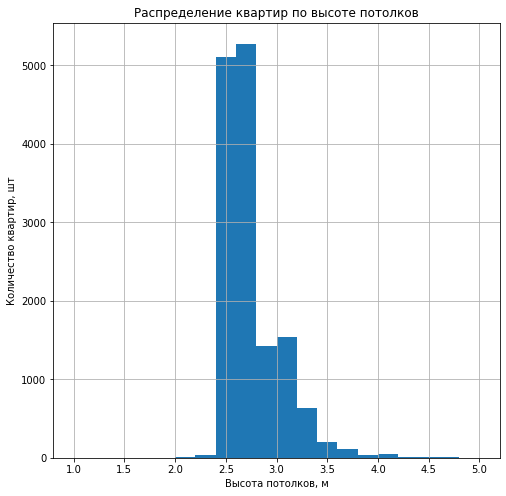

In [33]:
df_rep_ceiling_not_nan.hist(column='ceiling_height', bins=20, range=(1, 5), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество квартир, шт')
plt.show()

In [36]:
display(df_group_celling.sort_values(('count'),ascending=False).head(20))
display(df_group_celling.sort_values(('count'),ascending=False).tail(20))

,count,min,max,mean,median
floors_group,,,,,
"(2.0, 5.0]",4848,2.00,100.0,2.838738,2.60
"(5.0, 10.0]",4541,2.00,32.0,2.727144,2.60
"(15.0, 60.0]",3222,1.75,27.5,2.760953,2.70
"(10.0, 15.0]",1647,1.00,22.6,2.684208,2.65
"(0.0, 2.0]",223,1.20,27.0,2.996009,2.70


,count,min,max,mean,median
floors_group,,,,,
"(2.0, 5.0]",4848,2.00,100.0,2.838738,2.60
"(5.0, 10.0]",4541,2.00,32.0,2.727144,2.60
"(15.0, 60.0]",3222,1.75,27.5,2.760953,2.70
"(10.0, 15.0]",1647,1.00,22.6,2.684208,2.65
"(0.0, 2.0]",223,1.20,27.0,2.996009,2.70


#### Вывод по потолкам № 2: <a id="ciels_conclutions_2"></a>
Все упражнения были лишними. Как бы мы не "крутили" высоту потолков, среднее и медианное значение указывает нам на то, что превалирующее большинство квартир со страндратными потолками 2,7 метра, независимо от этажности дома. Отсюда можно сделать вывод, что пропуски можно заполнить стандартным ГОСТОВским значением 2,7 метра, что мы и сделаем.

In [37]:
df_rep.loc[(df_rep['ceiling_height'] == -1), 'ceiling_height'] = 2.7
df_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23565 non-null float64
living_area             21752 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 23650 non-null float64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
cityCenters_nearest     18139 non-null float64
parks_around3000        18140 non-null float64
parks_nearest           8064 non-null float64
ponds_ar

In [38]:
display(df_rep.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23565.000000,21752.000000,23650.000000,21381.000000,23650.000000,18116.000000,18139.000000,18140.000000,8064.000000,18140.000000,9085.000000,20470.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.743677,10.675875,34.448356,5.893277,10.566403,0.591712,28803.225878,14197.860742,0.611577,490.830729,0.769680,518.059879,180.753200
std,5.682278,1.089640e+07,35.661808,1.078620,0.988099,6.594823,22.037664,4.883317,5.901753,0.959662,12637.314144,8606.830295,0.802003,342.554386,0.937948,277.841733,219.777916
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,26756.500000,13105.000000,0.000000,454.500000,1.000000,502.000000,95.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


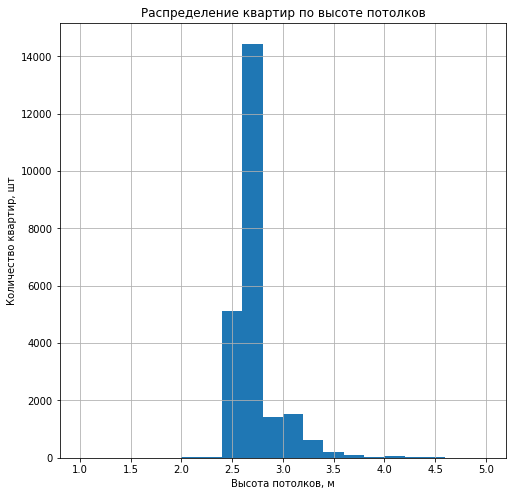

In [39]:
df_rep.hist(column='ceiling_height', bins=20, range=(1, 5), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество квартир, шт')
plt.show()

### III. Добавление в таблицу необходимых солбцов <a id="new_cols"></a>

#### 3.1 Посчитаем и добавим цену квадратного метра <a id="new_col_m2"></a>

In [40]:
df_rep['price_per_m2'] = df_rep['last_price'] / df_rep['total_area']
display(df_rep.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000.0,40.40,2018-12-04,1,2.70,11.0,18.60,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
2,10,5196000.0,56.00,2015-08-20,2,2.70,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000.0,159.00,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000
5,10,2890000.0,30.40,2018-09-10,1,2.70,12.0,14.40,5,False,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474
6,6,3700000.0,37.30,2017-11-02,1,2.70,26.0,10.60,6,False,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456
7,5,7915000.0,71.60,2019-04-18,2,2.70,24.0,NaN,22,False,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.692737
8,20,2900000.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.764777
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164


#### 3.2 Добавим три столбца: день недели, месяц и год публикации объявления <a id="new_3_col"></a>

In [41]:
df_rep['weekday_exposition'] = df_rep['first_day_exposition'].dt.weekday

In [42]:
print(sorted(df_rep['weekday_exposition'].unique()))

[0, 1, 2, 3, 4, 5, 6]


In [43]:
def cor_weekday(row):
    if row['weekday_exposition'] == 0:
        return 'пн'
    if row['weekday_exposition'] == 1:
        return 'вт' 
    if row['weekday_exposition'] == 2:
        return 'ср'
    if row['weekday_exposition'] == 3:
        return 'чт'
    if row['weekday_exposition'] == 4:
        return 'пт'
    if row['weekday_exposition'] == 5:
        return 'сб'
    if row['weekday_exposition'] == 6:
        return 'вс'

In [44]:
df_rep['weekday_exposition'] = df_rep.apply(cor_weekday, axis=1)
df_rep.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,чт
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,вт
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,чт
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,пт
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,вт


In [53]:
df_rep['month_exposition'] = df_rep['first_day_exposition'].dt.month

In [54]:
df_rep['year_exposition'] = df_rep['first_day_exposition'].dt.year

In [55]:
display(df_rep.head(10))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,чт,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.70,11.0,18.60,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,вт,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.70,5.0,34.30,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,чт,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,пт,7,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,вт,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,2.70,12.0,14.40,5,False,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.789474,пн,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,2.70,26.0,10.60,6,False,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,99195.710456,чт,11,2017,другой,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,2.70,24.0,NaN,22,False,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,110544.692737,чт,4,2019,другой,NaN,0.263966
8,20,2900000.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,87454.764777,ср,5,2018,другой,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,88524.590164,вс,2,2017,другой,0.714754,0.106557


#### 3.3 Добавим в таблицу столбец "Этаж" с категориальными значениями: первый, последний, другой <a id="floors_cat"></a>

In [56]:
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'       

In [57]:
df_rep['floor_category'] = df_rep.apply(floor_category, axis=1)
df_rep.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,чт,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.70,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,вт,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.70,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,чт,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,пт,7,2015,другой,NaN,NaN
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,вт,6,2018,другой,0.320000,0.410000


#### 3.4 Добавим соотношение жилой и общей площади, а также отношение площади кухни к общей <a id="livivng_total_area"></a>

In [58]:
df_rep['living_area_ratio'] = df_rep['living_area'] / df_rep['total_area']

In [59]:
df_rep['kitchen_area_ratio'] = df_rep['kitchen_area'] / df_rep['total_area']

In [60]:
df_rep.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
3112,13,7950000.0,70.0,2015-08-31,3,2.70,5.0,47.00,4,False,False,False,13.0,0.0,Санкт-Петербург,25900.0,4475.0,1.0,700.0,1.0,586.0,961.0,113571.428571,пн,8,2015,другой,0.671429,0.185714
9590,11,8420000.0,50.0,2019-04-12,2,3.20,5.0,28.90,3,False,False,False,9.1,0.0,Санкт-Петербург,22435.0,3084.0,2.0,742.0,1.0,69.0,NaN,168400.000000,пт,4,2019,другой,0.578000,0.182000
19951,8,3200000.0,35.0,2017-02-02,1,2.70,22.0,15.08,22,False,False,False,9.3,0.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,109.0,91428.571429,чт,2,2017,последний,0.430857,0.265714
18017,0,1700000.0,43.7,2017-09-04,2,2.60,5.0,31.10,1,False,False,False,5.3,0.0,поселок Мичуринское,NaN,NaN,NaN,NaN,NaN,NaN,45.0,38901.601831,пн,9,2017,первый,0.711670,0.121281
6289,13,4440000.0,40.5,2018-03-02,1,2.64,17.0,19.00,15,False,False,False,10.6,0.0,Санкт-Петербург,32796.0,11871.0,1.0,388.0,0.0,NaN,209.0,109629.629630,пт,3,2018,другой,0.469136,0.261728


### IV. Проведем исследовательский анализ данных: <a id="exploratory_analysis"></a>

#### 4.1 Исследуем параметры: площадь, цена, число комнат, высота потолков <a id="s_price_rooms_ceils"></a>

In [61]:
display(df_rep['total_area'].describe())

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

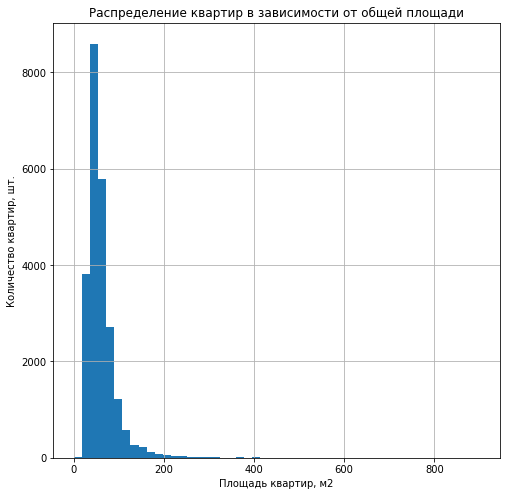

In [62]:
df_rep.hist(column='total_area', bins=50, range=(0, 900), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир в зависимости от общей площади')
plt.xlabel('Площадь квартир, м2')
plt.ylabel('Количество квартир, шт.')
plt.show()

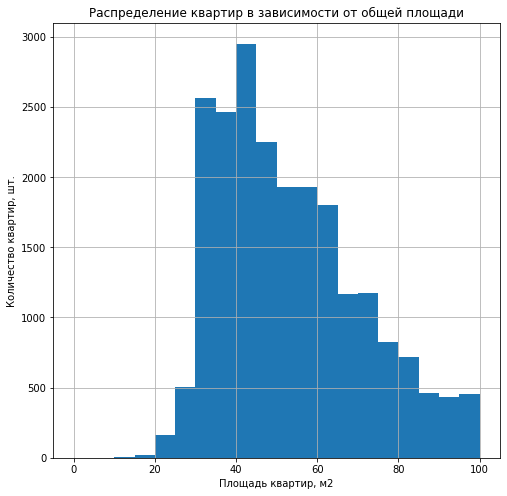

In [63]:
df_rep.hist(column='total_area', bins=20, range=(0, 100), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир в зависимости от общей площади')
plt.xlabel('Площадь квартир, м2')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Вывод по площади: <a id="s_conc"></a>
- По гистаграммам видно, что у нас вырисовывается распределение Пуассона.
- Средняя площодь продаваемых квартир: 60 м2
- Медиання площадь: 52 м2
- Минимальная площадь: 12 м2
- Максимальная площадь: 900 м2
- Большая часть предложений находится в дапазоне от 30 до 60 м2


In [64]:
display(df_rep['last_price'].describe())

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

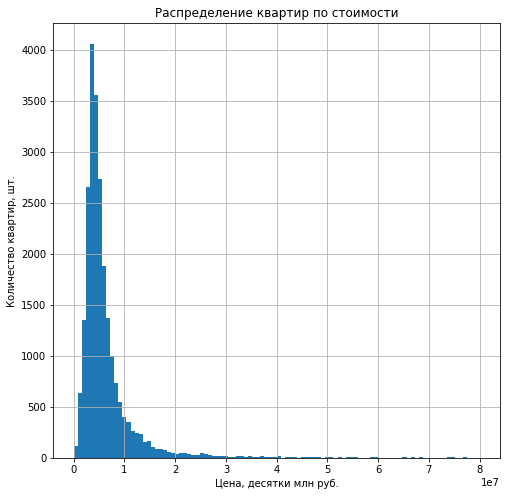

In [65]:
df_rep.hist(column='last_price', bins=100, range=(0, 80000000), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по стоимости')
plt.xlabel('Цена, десятки млн руб.')
plt.ylabel('Количество квартир, шт.')
plt.show()

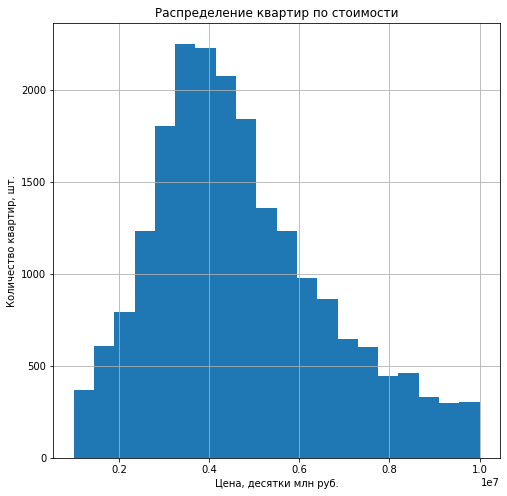

In [66]:
df_rep.hist(column='last_price', bins=20, range=(1000000,10000000), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по стоимости')
plt.xlabel('Цена, десятки млн руб.')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Вывод по цене: <a id="price_conc"></a>
- По гистаграммам видно, что у нас вырисовывается распределение Пуассона с длинным "хвостом", отсюда такая разница между медианной ценой 4,65 млн. руб и средней арифметической 6,5 млн. руб.
- Минимальная цена: 1,2 млн.руб.
- Максимальная цена: 760 млн. руб.
- Большая часть предложений находится в диапозоне от 3х до 5 млн. руб.

In [67]:
display(df_rep['rooms'].describe())

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

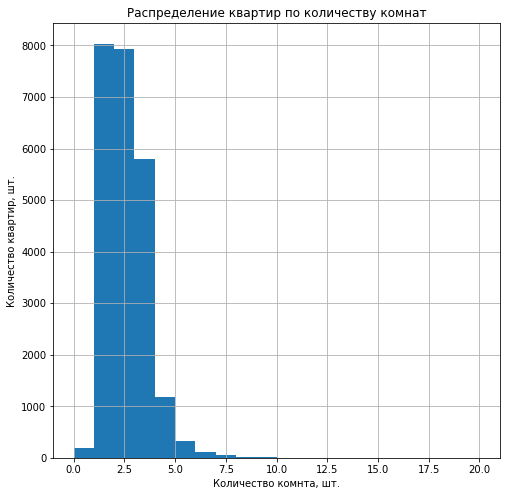

In [68]:
df_rep.hist(column='rooms', bins=20, range=(0,20), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по количеству комнат')
plt.xlabel('Количество комнта, шт.')
plt.ylabel('Количество квартир, шт.')
plt.show()

In [69]:
df_rep['rooms'].corr(df_rep['studio'])

-0.14737099852232627

In [70]:
df_rep.query('rooms == 0')['rooms'].count()

197

In [71]:
df_rep.query('studio == 1')['studio'].count()

149

In [72]:
df_rep.query('rooms == 0 and studio == 1')['rooms'].count()

138

#### Вывод по количеству комнат: <a id="count_rooms_conc"></a>
- По гистаграммам видно, что у нас вырисовывается распределение Пуассона.
- Среднее число комнат продаваемых квартир: 2 
- Медианное число комнат: 2 
- Минимальное число комнат: 0 Большая часть из эти предложений: квартиры-студии
- Максимальное число комнат: 19
- Большая часть предложений находится в дапазоне от 1 до 3 комнат

In [73]:
display(df_rep['ceiling_height'].describe())

count    23650.000000
mean         2.743677
std          0.988099
min          1.000000
25%          2.600000
50%          2.700000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

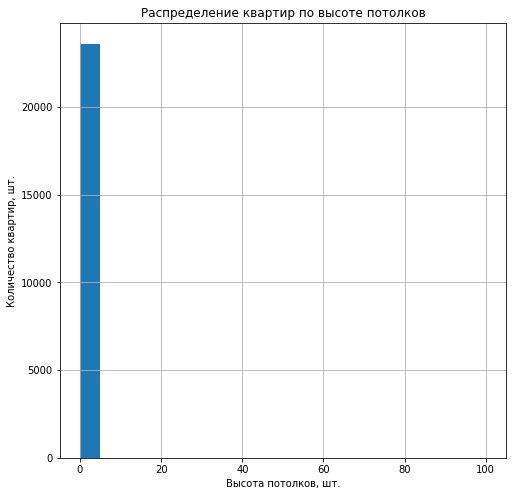

In [74]:
df_rep.hist(column=['ceiling_height'], bins=20, range=(0,100), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков, шт.')
plt.ylabel('Количество квартир, шт.')
plt.show()

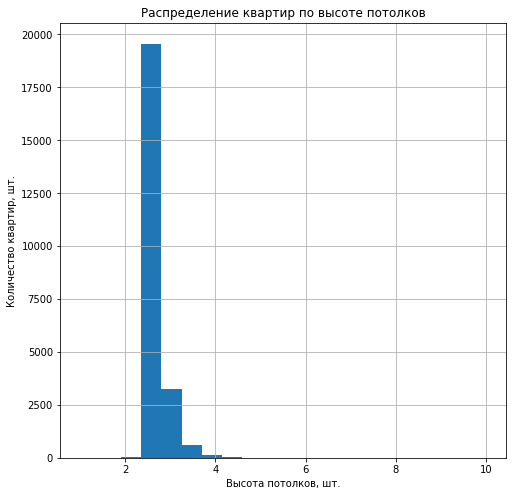

In [75]:
df_rep.hist(column=['ceiling_height'], bins=20, range=(1,10), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по высоте потолков')
plt.xlabel('Высота потолков, шт.')
plt.ylabel('Количество квартир, шт.')
plt.show()

#### Вывод по высоте потолков: <a id="ceils_conc"></a>
- Эти данные мы уже более внимательно исследовали ранее
- По гистаграммам видно, что у нас вырисовывается распределение Пуассона
- Средняя высота потолков: 2,7 м.
- Медианная высота потолков: 2,7 м.
- Минимальная высота потолков: 1 м. - вероятно домик гномиков в дупле волшебного дерева или аномалия
- Максимальная высота потолков: 100 м. - может быть замок вампиров или, опять таки, аномалия
- Большая часть предложений находится в дапазоне от 2,5 до 3 метров.

#### 4.2 Изучим время продажи квартиры <a id="t_sold_flats"></a>

In [76]:
display(df_rep['days_exposition'].describe())

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

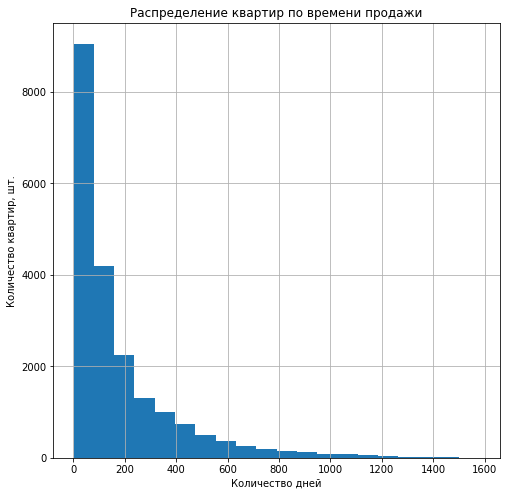

In [77]:
df_rep.hist(column=['days_exposition'], bins=20, range=(1,1580), figsize=(8, 8))
plt.grid(True)
plt.title('Распределение квартир по времени продажи')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир, шт.')
plt.show()

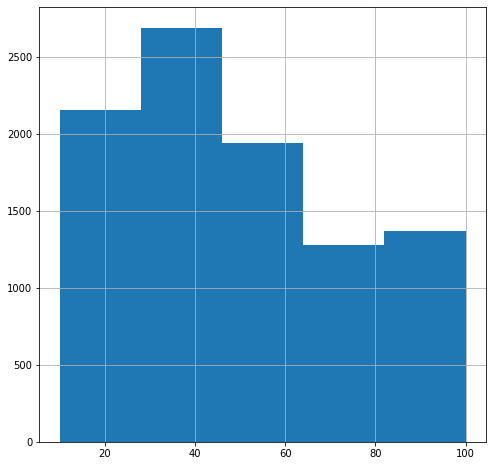

In [78]:
pd.Series(df_rep['days_exposition']).hist(bins=5, range=(10,100), figsize=(8, 8))

#### Вывод по времени продажи квартиры: <a id="con_t_sold_flats"></a>
- Чаще всего квартиры продаются за 2 месяца (от 50 до 60 дней)
- В среднем квартиры продаются за полгода (180 дней)
- Медианное значение продажи квартиры 95 дней
- Быстрой продажу можно считать, если у квартиры нашелся новый владелец до 45 дней (Первый квартиль выборки)

#### 4.3. Уберем редкие и выбивающиеся значения из выборки <a id="one_offs"></a>

In [79]:
display(df_rep.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,month_exposition,year_exposition,living_area_ratio,kitchen_area_ratio
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23565.000000,21752.000000,23650.000000,21381.000000,23650.000000,18116.000000,18139.000000,18140.000000,8064.000000,18140.000000,9085.000000,20470.000000,2.365000e+04,23650.000000,23650.000000,21752.000000,21381.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.743677,10.675875,34.448356,5.893277,10.566403,0.591712,28803.225878,14197.860742,0.611577,490.830729,0.769680,518.059879,180.753200,9.943225e+04,6.401564,2017.370021,0.564750,0.187372
std,5.682278,1.089640e+07,35.661808,1.078620,0.988099,6.594823,22.037664,4.883317,5.901753,0.959662,12637.314144,8606.830295,0.802003,342.554386,0.937948,277.841733,219.777916,5.033794e+04,3.491418,1.037806,0.105385,0.072972
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,1.000000,2014.000000,0.021583,0.025381
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18575.750000,9241.000000,0.000000,288.000000,0.000000,293.000000,45.000000,7.661497e+04,3.000000,2017.000000,0.495157,0.133333
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,26756.500000,13105.000000,0.000000,454.500000,1.000000,502.000000,95.000000,9.500000e+04,6.000000,2017.000000,0.567860,0.172414
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37294.000000,16293.000000,1.000000,612.000000,1.000000,730.000000,231.000000,1.142742e+05,10.000000,2018.000000,0.637778,0.232432
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.907500e+06,12.000000,2019.000000,1.000000,0.787879


In [80]:
df_rep.query('total_area == 900 or ceiling_height == 100 or ceiling_height <= 1 or ceiling_height >= 50 or last_price >= 500000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
12971,19,763000000.0,400.0,2017-09-30,7,2.7,10.0,250.0,10,False,False,False,NaN,2.0,Санкт-Петербург,25108.0,3956.0,1.0,530.0,3.0,756.0,33.0,1.907500e+06,сб,9,2017,последний,0.625000,NaN
19540,8,420000000.0,900.0,2017-12-06,12,2.8,25.0,409.7,25,False,False,False,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0,4.666667e+05,ср,12,2017,последний,0.455222,0.124444
22590,16,6000000.0,55.0,2018-10-31,2,1.0,12.0,32.4,7,False,False,False,10.0,0.0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0,1.090909e+05,ср,10,2018,другой,0.589091,0.181818
22869,0,15000000.0,25.0,2018-07-25,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,6.000000e+05,ср,7,2018,последний,0.560000,0.440000


#### Нам кажется, что стоит избавиться от "Замков вампиров" и "Землянок гномов" из нашей выборки.
Речь идет о:
- 900 метровой квартире
- квартире со 100-метровыми потолкам
- квартире, у которой потолки меньше 1 метра
- квартире, которая дорже 700 000 000 руб.

#### Чтобы не потерять все данные, мы запишем их без аномалий и всплесков в df_stil

In [81]:
df_stil = df_rep.query('total_area != 900 and ceiling_height != 100 and ceiling_height >= 1 and ceiling_height <= 50 and last_price <= 500000000')

In [82]:
df_stil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23647 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23647 non-null int64
last_price              23647 non-null float64
total_area              23647 non-null float64
first_day_exposition    23647 non-null datetime64[ns]
rooms                   23647 non-null int64
ceiling_height          23647 non-null float64
floors_total            23562 non-null float64
living_area             21749 non-null float64
floor                   23647 non-null int64
is_apartment            23647 non-null bool
studio                  23647 non-null bool
open_plan               23647 non-null bool
kitchen_area            21379 non-null float64
balcony                 23647 non-null float64
locality_name           23647 non-null object
airports_nearest        18113 non-null float64
cityCenters_nearest     18136 non-null float64
parks_around3000        18137 non-null float64
parks_nearest           8062 non-null float64
ponds_ar

#### 4.4 Разберемся, какие факторы больше всего влияют на стоимость квартиры <a id="factors_price"></a>

#### Посмотрим, зависит ли цена от площади, числа комнат, удалённости от центра<a id="for_revue"></a>

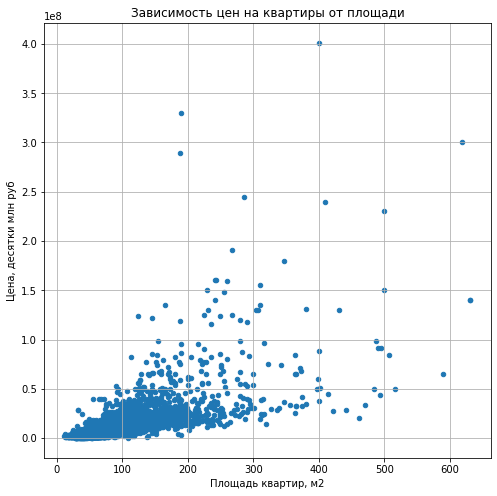

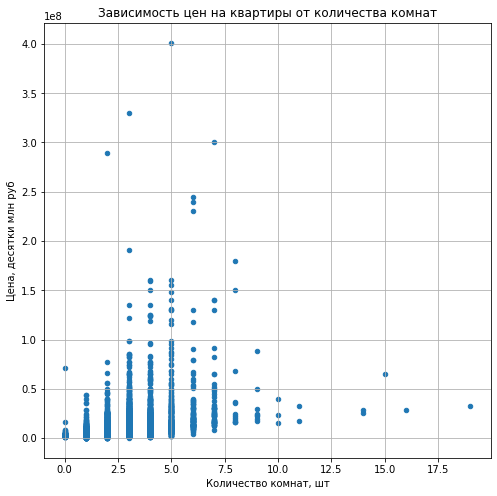

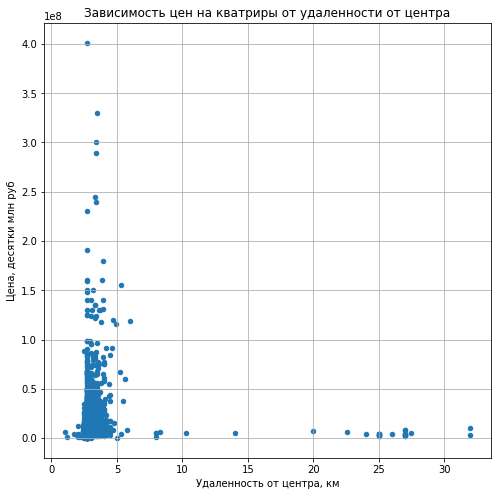

In [83]:
for column in df_stil[['total_area', 'rooms', 'ceiling_height']]:
    if column == 'total_area':
        
        df_stil.plot(x=column, y='last_price', kind='scatter', figsize=(8, 8))
        plt.grid(True)
        plt.title('Зависимость цен на квартиры от площади')
        plt.xlabel('Площадь квартир, м2')
        plt.ylabel('Цена, десятки млн руб')
        plt.show()
        
    if column == 'rooms':
        
        df_stil.plot(x=column, y='last_price', kind='scatter', figsize=(8, 8))
        plt.grid(True)
        plt.title('Зависимость цен на квартиры от количества комнат')
        plt.xlabel('Количество комнат, шт')
        plt.ylabel('Цена, десятки млн руб')
        plt.show()
    
    if column == 'ceiling_height':    
        
        df_stil.plot(x=column, y='last_price', kind='scatter', figsize=(8, 8))
        plt.title('Зависимость цен на кватриры от удаленности от центра')
        plt.grid(True)
        plt.xlabel('Удаленность от центра, км')
        plt.ylabel('Цена, десятки млн руб') 
        plt.show()

#### Взглянем повнимательнее на зависимость цены от площади: 

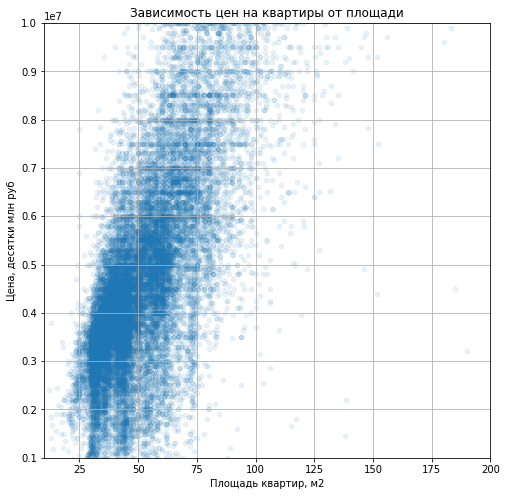

In [84]:
df_stil.plot(x='total_area', y='last_price', kind='scatter', ylim=(1000000, 10000000), 
             xlim=(10, 200), figsize=(8, 8), alpha=(0.09))
plt.grid(True)
plt.title('Зависимость цен на квартиры от площади')
plt.xlabel('Площадь квартир, м2')
plt.ylabel('Цена, десятки млн руб')
plt.show()

#### Вывод по зависимости  цены от площади: <a id="area_price"></a>
Зависимость есть. Чем больше квартира, тем выше ее цена. Особенно хорошо видно эту зависимость в популярном сегменте квартир от 25 до 100 метров.

#### Взглянем повнимательнее на количество комнат квартир:

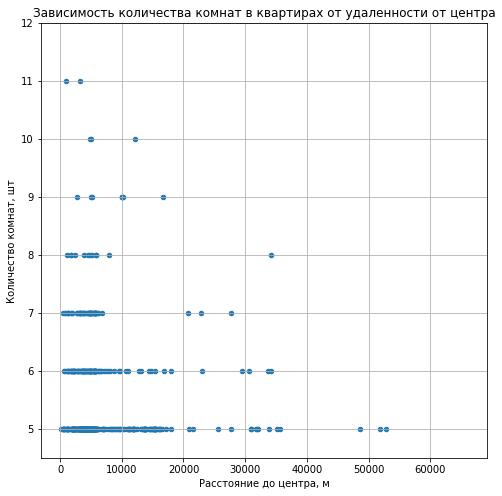

In [85]:
df_stil.plot(x='cityCenters_nearest', y='rooms', kind='scatter', ylim=(4.5, 12), figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость количества комнат в квартирах от удаленности от центра')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Количество комнат, шт')
plt.show()

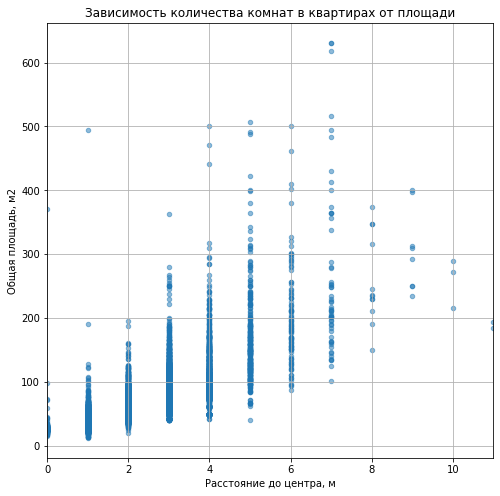

In [86]:
df_stil.plot(x='rooms', y='total_area', xlim=(0, 11), kind='scatter', alpha=(0.5), figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость количества комнат в квартирах от площади')
plt.xlabel('Расстояние до центра, м')
plt.ylabel('Общая площадь, м2')
plt.show()

In [87]:
df_stil.groupby('rooms')['total_area'].agg(['mean']).sort_values(by=['mean'])

,mean
rooms,
0,29.279746
1,37.629030
2,55.842278
3,77.748020
4,107.681787
5,161.474816
11,188.900000
6,201.537619
8,259.233333


####  Вывод по зависимости цены от количества комнат: <a id="room_price"></a>
Зависимость (восходящий тренд) хорошо прослеживается у квартир от 1 до 6 комнат.Чем больше комнат, тем выше цена, дальше тренд ломатется, и корреляция теряется.
Недвижимость с 6 и более комнататами ценится не так сильно. Прежде всего это связано с тем, что площади таких квартир зачастую меньше, что видно на графике зависимости кол-ва комнта и общей площади. Возможно, это бывшие коммунальные квартиры. Помимо этого, я думаю, что на цену влияет более сниженный спрос на такие предложения (мое мнение).

#### Взглянем повнимательнее на зависимость цены от удаленности от центра:

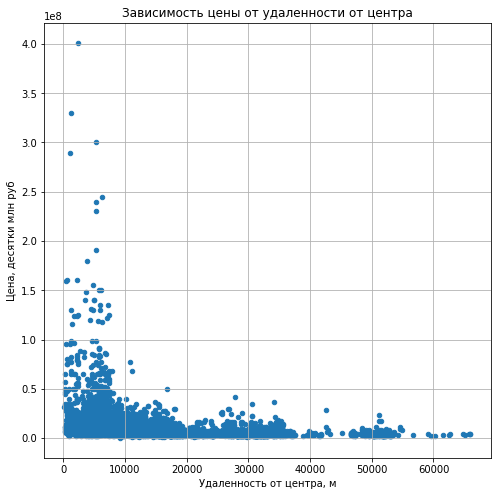

In [88]:
df_stil.plot(y='last_price', x='cityCenters_nearest', kind='scatter', figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость цены от удаленности от центра')
plt.xlabel('Удаленность от центра, м')
plt.ylabel('Цена, десятки млн руб')
plt.show()

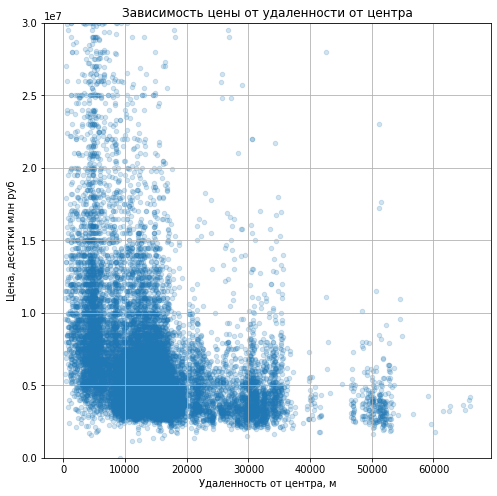

In [89]:
df_stil.plot(y='last_price', x='cityCenters_nearest', kind='scatter',ylim=(0,30000000), alpha=(0.2), figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость цены от удаленности от центра')
plt.xlabel('Удаленность от центра, м')
plt.ylabel('Цена, десятки млн руб')
plt.show()

####  Вывод по зависимости цен от удаленности от центра <a id="center_price"></a>
Зависимость есть. Цена растет с каждым метром приближения к центру

#### Взглянем на зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом

In [90]:
df_stil_pivot = df_stil.groupby('floor_category')['last_price'].agg(['mean']).sort_values(by=['mean'])
display(df_stil_pivot)

,mean
floor_category,
первый,4.800465e+06
другой,6.675825e+06
последний,7.005689e+06


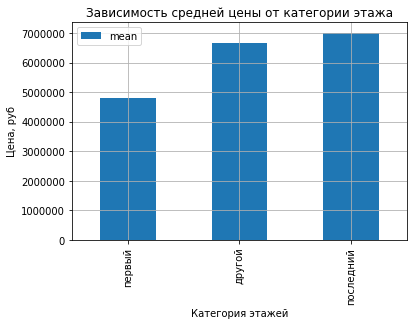

In [91]:
df_stil_pivot.plot(kind="bar", stacked=True)
plt.grid(True)
plt.title('Зависимость средней цены от категории этажа')
plt.xlabel('Категория этажей')
plt.ylabel('Цена, руб')
plt.show()

#### Вывод по зависимости цены от категории этажа (первый, последний, другой) <a id="flat_price"></a>
Если смотреть среднее арифметическое, то видно, что больше всего ценятся последние этажи дома. За красивый вид нужно платить

#### Изучим зависимость цены от даты размещения: дня недели, месяца и года

,mean
weekday_exposition,
вс,6.249360e+06
пт,6.364605e+06
вт,6.393782e+06
пн,6.510815e+06
ср,6.520022e+06
сб,6.591197e+06
чт,6.711767e+06


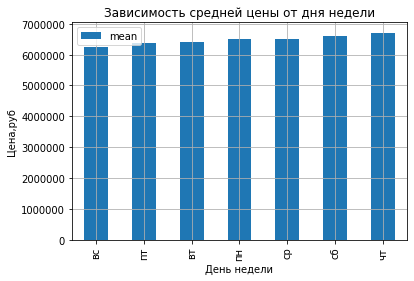

,mean
month_exposition,
10,6.235166e+06
6,6.311184e+06
8,6.352839e+06
3,6.362919e+06
9,6.446180e+06
11,6.461458e+06
2,6.464463e+06
5,6.594777e+06
7,6.636387e+06


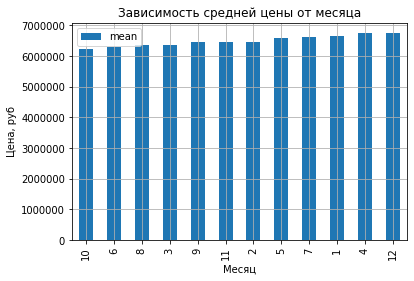

,mean
year_exposition,
2014,1.204660e+07
2015,8.592727e+06
2016,6.829415e+06
2017,6.442864e+06
2018,5.951153e+06
2019,6.782388e+06


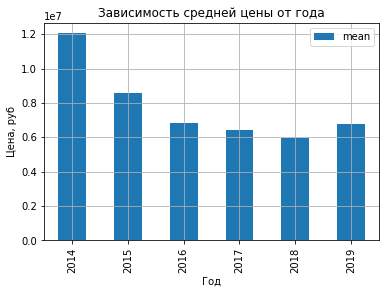

In [92]:
for column in df_stil[['weekday_exposition', 'month_exposition', 'year_exposition', 'last_price']]:
    
    if column == 'weekday_exposition':
        
        df_stil_pivot_weekday = df_stil.groupby(column)['last_price'].agg(['mean']).sort_values(by=['mean'])
        display(df_stil_pivot_weekday)

        df_stil_pivot_weekday.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от дня недели')
        plt.xlabel('День недели')
        plt.ylabel('Цена,руб')
        plt.show()

    if column == 'month_exposition':
        
        df_stil_pivot_month = df_stil.groupby(column)['last_price'].agg(['mean']).sort_values(by=['mean'])
        display(df_stil_pivot_month)

        df_stil_pivot_month.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от месяца')
        plt.xlabel('Месяц') 
        plt.ylabel('Цена, руб')
        plt.show()
    
    if column == 'year_exposition':

        df_stil_pivot_year = df_stil.groupby(column)['last_price'].agg(['mean']).sort_values(by=['year_exposition'])
        display(df_stil_pivot_year)

        df_stil_pivot_year.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от года')
        plt.xlabel('Год')
        plt.ylabel('Цена, руб')
        plt.show()

#### Вывод по зависимости цены от дня/месяца/года подачи объявления: <a id="date_d_m_y_price"></a>
- Дороже всего выставляют квартиры на продажу в четверг
- Пик цены по году- декабрь и апрель. Думаю, что это сезонность спроса.
- Если смотреть в ретроспективе с 2014 по 2019 год, то видно, что квартиры дешевели за весь этот период, кроме 2019 года. Возможно, рост цен в 2019 связан со снижением ставок по ипотеке.

#### 4.5 Выберем 10 населённых пунктов с наибольшим числом объявлений и проведем по ним анализ <a id="1oc_top_10"></a>

In [93]:
df_stil_pivot_location = df_stil.groupby('locality_name')['last_price'].agg(['count', 'mean']).reset_index().sort_values(
    by=['count'], ascending=False)
display(df_stil_pivot_location.head(10))

,locality_name,count,mean
33,Санкт-Петербург,15718,7.987828e+06
291,посёлок Мурино,522,3.672049e+06
326,посёлок Шушары,440,4.108082e+06
3,Всеволожск,398,3.789068e+06
32,Пушкин,369,6.469036e+06
13,Колпино,338,3.964021e+06
296,посёлок Парголово,327,4.488075e+06
6,Гатчина,307,3.488337e+06
93,деревня Кудрово,299,4.234158e+06
4,Выборг,237,3.250983e+06


In [94]:
stil_pivot_location_top_10 = list(df_stil_pivot_location['locality_name'].head(10))
print(stil_pivot_location_top_10)

['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина', 'деревня Кудрово', 'Выборг']


In [95]:
df_stil_location_top_10 = df_stil.query('locality_name in @stil_pivot_location_top_10')
display(df_stil_location_top_10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,чт,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,2.70,11.0,18.6,1,False,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,вт,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,2.70,5.0,34.3,4,False,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,чт,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,2.70,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,пт,7,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,вт,6,2018,другой,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15.0,16.3,4,False,False,False,9.10,2.0,Санкт-Петербург,17284.0,16081.0,1.0,353.0,2.0,652.0,29.0,100566.572238,ср,2,2018,другой,0.461756,0.257790
23690,3,5500000.0,52.00,2018-07-19,2,2.70,5.0,31.0,2,False,False,False,6.00,0.0,Санкт-Петербург,20151.0,6263.0,1.0,300.0,0.0,NaN,15.0,105769.230769,чт,7,2018,другой,0.596154,0.115385
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25.0,40.3,7,False,False,False,10.60,1.0,Санкт-Петербург,19424.0,4489.0,0.0,NaN,1.0,806.0,519.0,129903.978052,чт,10,2016,другой,0.552812,0.145405
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,False,False,13.83,0.0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,72490.845228,вт,3,2017,другой,0.547792,0.103356


In [96]:
df_stil_location_top_10.groupby('locality_name')['last_price'].agg(['count', 'mean']).reset_index().sort_values(
    by=['count'], ascending=False)

,locality_name,count,mean
5,Санкт-Петербург,15718,7.987828e+06
7,посёлок Мурино,522,3.672049e+06
9,посёлок Шушары,440,4.108082e+06
0,Всеволожск,398,3.789068e+06
4,Пушкин,369,6.469036e+06
3,Колпино,338,3.964021e+06
8,посёлок Парголово,327,4.488075e+06
2,Гатчина,307,3.488337e+06
6,деревня Кудрово,299,4.234158e+06
1,Выборг,237,3.250983e+06


#### Посчитаем среднюю цену квадратного метра в этих населённых пунктах  и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья

In [97]:
df_group_top_10 = df_stil_location_top_10.groupby('locality_name')['price_per_m2'].agg(['mean']).reset_index().sort_values(
    by=['mean'], ascending=False)
display(df_group_top_10)

,locality_name,mean
5,Санкт-Петербург,114681.708906
4,Пушкин,103125.819291
6,деревня Кудрово,92473.547576
8,посёлок Парголово,90175.913458
7,посёлок Мурино,85752.189195
9,посёлок Шушары,78677.364217
3,Колпино,75424.579098
2,Гатчина,68746.146763
0,Всеволожск,68654.473986
1,Выборг,58141.909153


In [98]:
df_group_top_10.set_index('locality_name', inplace=True)


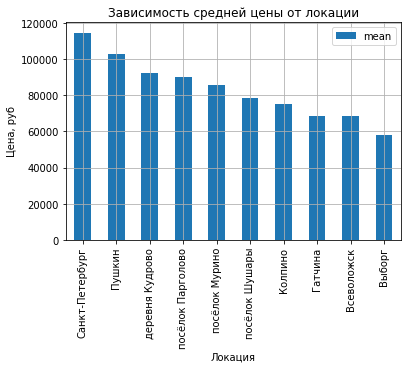

In [99]:
df_group_top_10.plot(kind="bar", stacked=True)
plt.grid(True)
plt.title('Зависимость средней цены от локации')
plt.xlabel('Локация')
plt.ylabel('Цена, руб')
plt.show()

#### Вывод по зависимости цены от населенного пунтка ( Топ 10): <a id="conclusions_loc_top_10"></a>
- Дороже всего м2 продаваемых квартир в Санкт-Петербурге
- Дешевде всего м2 продаваемых квартир в Выборге

#### 4.6 Изучим внимательнее предложения квартир в разрезе удаленности от центра Санкт-Петербурга <a id="flats_spb"></a>

#### Выделим квартиры в Санкт-Петербурге

In [100]:
df_stil['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [101]:
df_stil_SP = df_stil.query('locality_name == "Санкт-Петербург"')
df_stil_SP.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15718 entries, 0 to 23697
Data columns (total 29 columns):
total_images            15718 non-null int64
last_price              15718 non-null float64
total_area              15718 non-null float64
first_day_exposition    15718 non-null datetime64[ns]
rooms                   15718 non-null int64
ceiling_height          15718 non-null float64
floors_total            15648 non-null float64
living_area             14578 non-null float64
floor                   15718 non-null int64
is_apartment            15718 non-null bool
studio                  15718 non-null bool
open_plan               15718 non-null bool
kitchen_area            14340 non-null float64
balcony                 15718 non-null float64
locality_name           15718 non-null object
airports_nearest        15633 non-null float64
cityCenters_nearest     15657 non-null float64
parks_around3000        15657 non-null float64
parks_nearest           7282 non-null float64
ponds_ar

 #### Создадим столбец с расстоянием до центра в километрах и округлим до целых значений

In [102]:
display(df_stil_SP['cityCenters_nearest'].sample(10))

11847     4386.0
7659     10955.0
22202    11065.0
17383    13731.0
12962    10364.0
10503    12567.0
7741     22358.0
2810     14398.0
3042     14665.0
5155      1181.0
Name: cityCenters_nearest, dtype: float64

In [103]:
df_stil_SP['cityCenters_nearest_km'] = (round(df_stil_SP['cityCenters_nearest']/1000))
df_stil_SP[['cityCenters_nearest','cityCenters_nearest_km']].sample(10)

,cityCenters_nearest,cityCenters_nearest_km
23148,7921.0,8.0
11373,14760.0,15.0
7716,7302.0,7.0
14220,5908.0,6.0
15436,10792.0,11.0
22854,12386.0,12.0
9233,9508.0,10.0
8256,7791.0,8.0
4251,12267.0,12.0
22604,11298.0,11.0


#### Посчитаем среднюю цену для каждого километра

In [104]:
df_stil_SP['cityCenters_nearest_km'].unique()

array([16., 14.,  7.,  8., 12., 15., 11., 13., 10.,  2.,  4., 17.,  5.,
       nan,  9.,  3.,  6., 21., 18.,  1., 24., 26., 22., 20., 23., 25.,
        0., 27., 28., 19., 29.])

In [105]:
df_pivot_km = df_stil_SP.groupby('cityCenters_nearest_km')[['price_per_m2']].agg(['mean']).reset_index().sort_values(
    by=['cityCenters_nearest_km'], ascending=False)
display(df_pivot_km)

,cityCenters_nearest_km,price_per_m2
,,mean
29,29.0,72953.365445
28,28.0,81161.915320
27,27.0,132115.709459
26,26.0,89285.876593
25,25.0,91531.371618
24,24.0,85736.904595
23,23.0,91828.517765
22,22.0,91330.425050
21,21.0,94469.584582


In [106]:
df_pivot_km.set_index('cityCenters_nearest_km', inplace=True)

In [107]:
display(df_pivot_km)

,price_per_m2
,mean
cityCenters_nearest_km,
29.0,72953.365445
28.0,81161.915320
27.0,132115.709459
26.0,89285.876593
25.0,91531.371618
24.0,85736.904595
23.0,91828.517765
22.0,91330.425050


#### Построим график, который нам покажет, как цена зависит от удалённости от центра

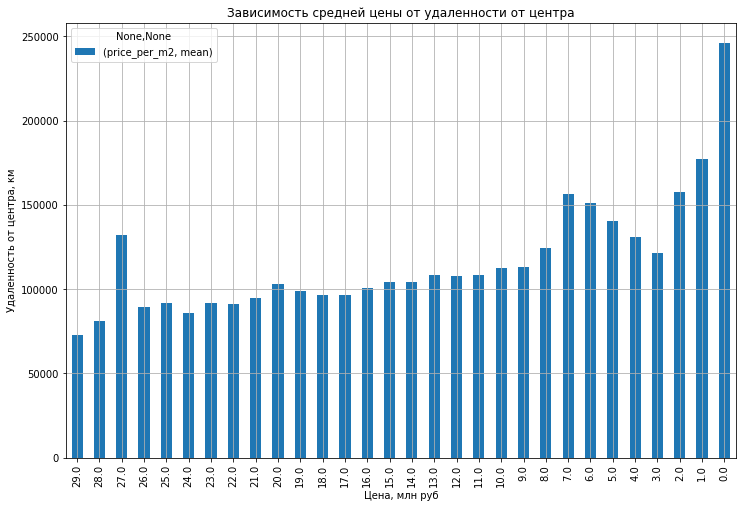

In [108]:
df_pivot_km.plot(kind="bar", stacked=True, grid=True,figsize=(12, 8))
plt.grid(True)
plt.title('Зависимость средней цены от удаленности от центра')
plt.xlabel('Цена, млн руб')
plt.ylabel('Удаленность от центра, км')
plt.show()

In [109]:
df_stil_SP_center = df_stil_SP.query('cityCenters_nearest_km <=3')
df_stil_SP_center.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m2,weekday_exposition,month_exposition,year_exposition,floor_category,living_area_ratio,kitchen_area_ratio,cityCenters_nearest_km
24,8,6500000.0,97.2,2015-10-31,2,2.70,3.0,46.5,1,False,False,False,19.6,0.0,Санкт-Петербург,20052.0,2336.0,3.0,411.0,3.0,124.0,265.0,66872.427984,сб,10,2015,первый,0.478395,0.201646,2.0
99,32,9600000.0,90.0,2017-09-26,4,2.70,5.0,67.0,2,False,False,False,8.0,0.0,Санкт-Петербург,23277.0,2818.0,0.0,NaN,0.0,NaN,104.0,106666.666667,вт,9,2017,другой,0.744444,0.088889,3.0
138,8,4800000.0,40.0,2017-11-18,2,2.70,3.0,29.0,2,False,False,False,6.0,0.0,Санкт-Петербург,23371.0,2913.0,0.0,NaN,2.0,729.0,80.0,120000.000000,сб,11,2017,другой,0.725000,0.150000,3.0
154,1,8200000.0,80.0,2018-11-06,3,4.15,3.0,44.2,2,False,False,False,12.2,0.0,Санкт-Петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0,102500.000000,вт,11,2018,другой,0.552500,0.152500,3.0
155,8,96000000.0,317.0,2017-07-07,4,3.50,3.0,183.0,3,False,False,False,NaN,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0,302839.116719,пт,7,2017,последний,0.577287,NaN,2.0


In [110]:
df_stil_SP_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 24 to 23648
Data columns (total 30 columns):
total_images              879 non-null int64
last_price                879 non-null float64
total_area                879 non-null float64
first_day_exposition      879 non-null datetime64[ns]
rooms                     879 non-null int64
ceiling_height            879 non-null float64
floors_total              877 non-null float64
living_area               825 non-null float64
floor                     879 non-null int64
is_apartment              879 non-null bool
studio                    879 non-null bool
open_plan                 879 non-null bool
kitchen_area              802 non-null float64
balcony                   879 non-null float64
locality_name             879 non-null object
airports_nearest          879 non-null float64
cityCenters_nearest       879 non-null float64
parks_around3000          879 non-null float64
parks_nearest             689 non-null float64
ponds_ar

#### Вывод по зависимости цены квартиры в СПб от удаленности от центра: <a id="conclusions_spb"></a>
- С 29 по 8 км от центра график имеет плавный восходящий тренд. Есть один всплеск на 27 км. Вероятно, туда попал какой-то дорогой район.
- С 8 по 3 км тренд ломается и становится нисходящим. Предлположу, что сюда попали районы города со старым жилым фондом.
- С 2 по 0 км идет резкое увеличение цены.
- Тренд ведет себя странно начиная с 8 километра. Предположим, что центр СПб с 7 по 0 км.
 
#### Нам кажется, что разумным будет взять для исследования центральную зону Санкт-Петербурга: предложения со 2-ого по 0-вой км. В эту выборку попадют 879 квартир

#### 4.7 Изучим сегмент квартир в центре <a id="center_flats_res"></a>

#### Посмотрим, зависит ли цена от площади и числа комнат

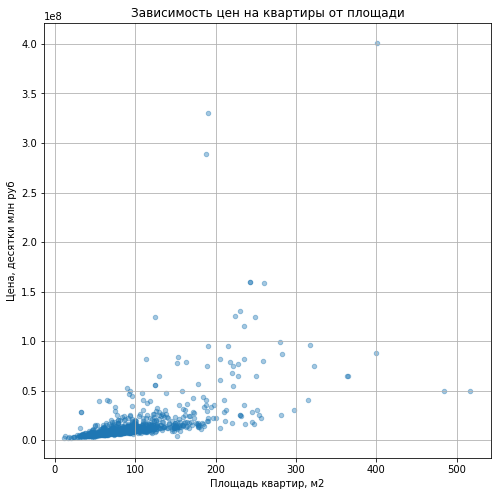

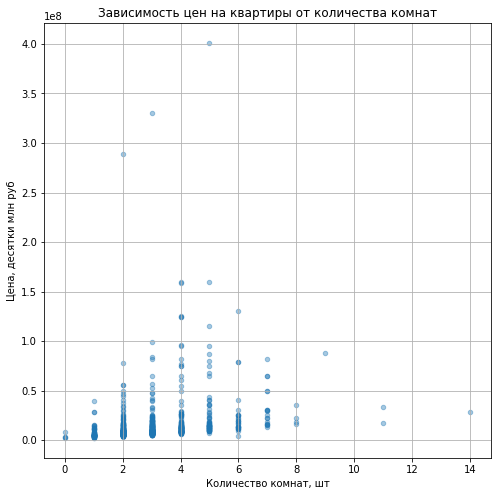

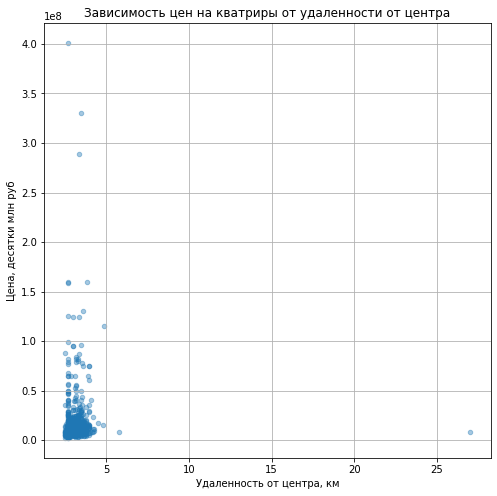

In [111]:
for column in df_stil_SP_center[['total_area', 'rooms', 'ceiling_height']]:
    if column == 'total_area':
        
        df_stil_SP_center.plot(x=column, y='last_price', kind='scatter', alpha=(0.4), figsize=(8, 8))
        plt.grid(True)
        plt.title('Зависимость цен на квартиры от площади')
        plt.xlabel('Площадь квартир, м2')
        plt.ylabel('Цена, десятки млн руб')
        plt.show()
        
    if column == 'rooms':
        
        df_stil_SP_center.plot(x=column, y='last_price', kind='scatter', alpha=(0.4), figsize=(8, 8))
        plt.grid(True)
        plt.title('Зависимость цен на квартиры от количества комнат')
        plt.xlabel('Количество комнат, шт')
        plt.ylabel('Цена, десятки млн руб')
        plt.show()
    
    if column == 'ceiling_height':    
        
        df_stil_SP_center.plot(x=column, y='last_price', kind='scatter', alpha=(0.4), figsize=(8, 8))
        plt.title('Зависимость цен на кватриры от удаленности от центра')
        plt.grid(True)
        plt.xlabel('Удаленность от центра, км')
        plt.ylabel('Цена, десятки млн руб') 
        plt.show()

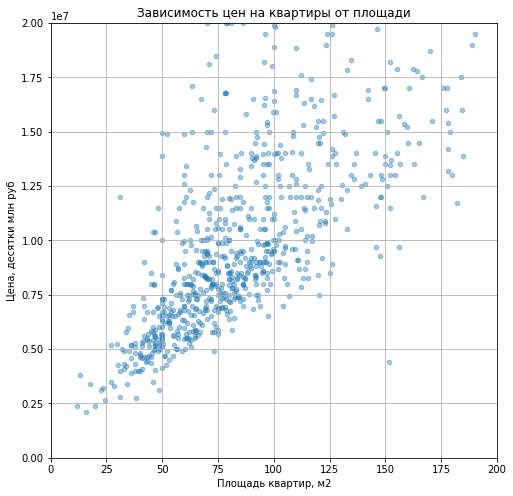

In [112]:
df_stil_SP_center.plot(x='total_area', y='last_price', kind='scatter', xlim=(0,200), ylim=(0, 20000000),alpha=(0.4), figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость цен на квартиры от площади')
plt.xlabel('Площадь квартир, м2')
plt.ylabel('Цена, десятки млн руб')
plt.show()

#### Вывод по зависимости цены от площади в СПб: <a id="conc_centet_flats_res"></a>
Зависимость есть. Чем больше квартира, тем выше ее цена. Особенно хорошо видно эту зависимость в популярном сегменте квартир от 25 до 100 метров. Аналогичную закономерность мы наблюдали по всей выборке.

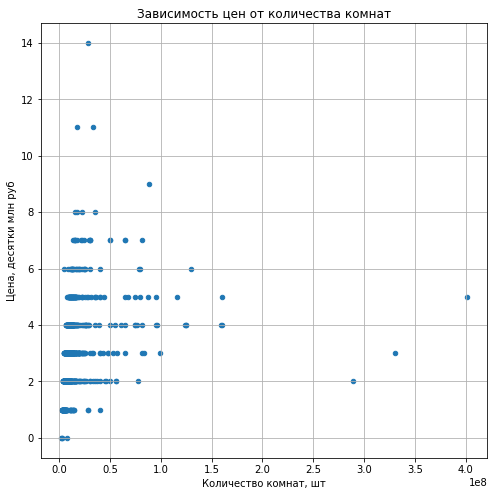

In [113]:
df_stil_SP_center.plot(x='last_price', y='rooms', kind='scatter', figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость цен от количества комнат')
plt.xlabel('Количество комнат, шт')
plt.ylabel('Цена, десятки млн руб')
plt.show()

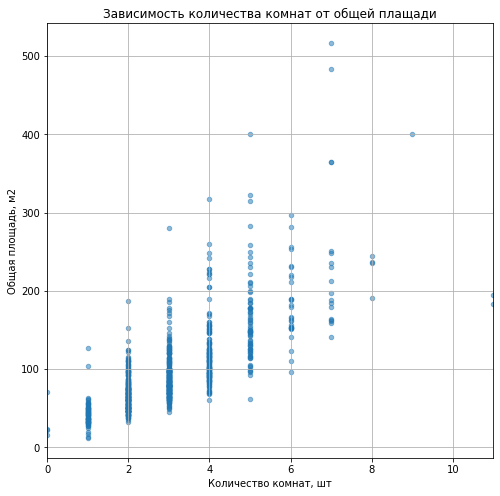

In [114]:
df_stil_SP_center.plot(x='rooms', y='total_area', xlim=(0, 11), kind='scatter', alpha=(0.5), figsize=(8, 8))
plt.grid(True)
plt.title('Зависимость количества комнат от общей плащади')
plt.xlabel('Количество комнат, шт')
plt.ylabel('Общая площадь, м2')
plt.show()

In [115]:
df_stil_SP_center.groupby('rooms')['total_area'].agg(['mean']).sort_values(by=['mean'])

,mean
rooms,
0,33.325000
1,42.623944
2,68.507899
3,89.760187
4,120.797763
5,164.033333
6,183.765517
11,188.900000
8,226.900000


#### Вывод по зависимости цены от количества комнат: <a id="conc_centet_flats_res_rooms"></a>
Зависимость (восходящий тренд) хорошо прослеживается у квартир от 1 до 6 комнат.Чем больше комнат, тем выше цена, дальше тренд ломатется, и корреляция теряется. Недвижимость с 6 и более комнатами ценится не так сильно. Прежде всего это связано с тем, что площади таких квартир зачастую меньше, что видно на графике зависимости кол-ва комнт и общей площади. Возможно, это бывшие коммунальные квартиры. Помимо этого, я думаю, что на цену влияет более сниженный спрос на такие предложения (наше мнение). 
Аналогичный вывод был нами сделан и по общей выборке.

#### Взглянем на зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом

In [116]:
df_stil_SP_center_pivot = df_stil_SP_center.groupby('floor_category')['last_price'].agg(['mean']).sort_values(by=['mean'])
display(df_stil_SP_center_pivot)

,mean
floor_category,
первый,1.030313e+07
другой,1.713803e+07
последний,1.777233e+07


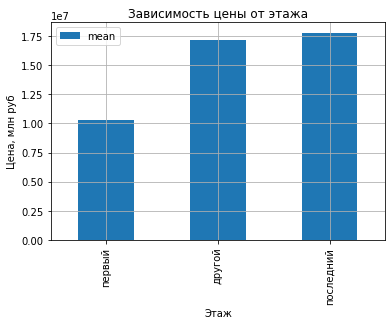

In [117]:
df_stil_SP_center_pivot.plot(kind="bar", stacked=True)
plt.grid(True)
plt.title('Зависимость цены от этажа')
plt.xlabel('Этаж')
plt.ylabel('Цена, млн руб')
plt.show()

#### Вывод по зависимости цены от категории этажа (первый, последний, другой) <a id="conc_centet_flats_res_floor"></a>
Если смотреть среднее арифметическое, то видно, что больше всего ценятся последние этажи дома. За красивый вид нужно платить. Особенно в центре :-)

#### Изучим зависимость цены от даты размещения: дня недели, месяца и года

,mean
weekday_exposition,
пт,1.424938e+07
пн,1.535779e+07
ср,1.541345e+07
вс,1.607084e+07
сб,1.726365e+07
чт,1.792367e+07
вт,1.806054e+07


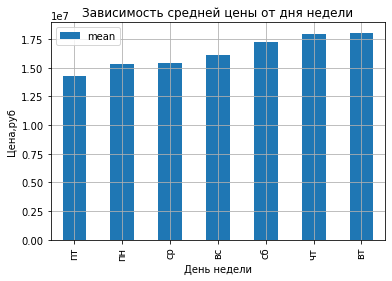

,mean
month_exposition,
10,6.235166e+06
6,6.311184e+06
8,6.352839e+06
3,6.362919e+06
9,6.446180e+06
11,6.461458e+06
2,6.464463e+06
5,6.594777e+06
7,6.636387e+06


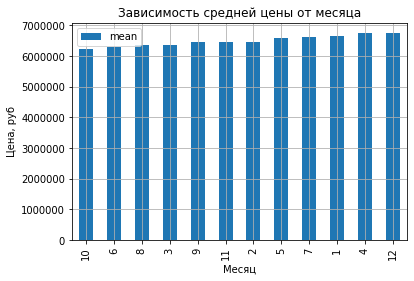

,mean
year_exposition,
2014,1.204660e+07
2015,8.592727e+06
2016,6.829415e+06
2017,6.442864e+06
2018,5.951153e+06
2019,6.782388e+06


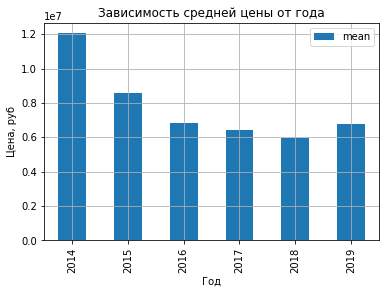

In [118]:
for column in df_stil_SP_center[['weekday_exposition', 'month_exposition', 'year_exposition', 'last_price']]:
    
    if column == 'weekday_exposition':
        
        df_stil_SP_center_pivot_weekday = df_stil_SP_center.groupby(column)['last_price'].agg(['mean']).sort_values(by=['mean'])
        display(df_stil_SP_center_pivot_weekday)

        df_stil_SP_center_pivot_weekday.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от дня недели')
        plt.xlabel('День недели')
        plt.ylabel('Цена,руб')
        plt.show()

    if column == 'month_exposition':
        
        df_stil_SP_center_pivot_month = df_stil.groupby(column)['last_price'].agg(['mean']).sort_values(by=['mean'])
        display(df_stil_SP_center_pivot_month)

        df_stil_SP_center_pivot_month.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от месяца')
        plt.xlabel('Месяц') 
        plt.ylabel('Цена, руб')
        plt.show()
    
    if column == 'year_exposition':

        df_stil_SP_center_pivot_year = df_stil.groupby(column)['last_price'].agg(['mean']).sort_values(by=['year_exposition'])
        display(df_stil_SP_center_pivot_year)

        df_stil_SP_center_pivot_year.plot(kind="bar", stacked=True)
        plt.grid(True)
        plt.title('Зависимость средней цены от года')
        plt.xlabel('Год')
        plt.ylabel('Цена, руб')
        plt.show()

#### Вывод по зависимости цены от дня/месяца/года подачи объявления: <a id="conc_centet_flats_res_data_d_m_y"></a>
- Дороже всего выставляют квартиры на продажу во вторник и четверг. По общей выборке выделялся только четверг.
- Пик цены по году - декабрь и апрель. Думаю, что это сезонность спроса - так же как и по всей выборке, но в центре в декабре скачок ощутимее.
- Если смотреть в ретроспективе с 2014 по 2019 год, то видно, что квартиры дешевели за весь этот период, кроме 2019 года. Возможно рост цен в 2019 связан со снижением ставок по ипотеке -  здесь все также, как и по всем остальным предложениям

### V. Общий вывод: <a id="total_conculution_"></a>



#### По времени продажи квартиры:
- Чаще всего квартиры продаются за 2 месяца (от 50 до 60 дней)
- В среднем квартиры продаются за полгода (180 дней)
- Медианное значение продажи квартиры 95 дней
- Быстрой продажу можно считать, если у квартиры нашелся новый владелец до 45 дней (Первый квартиль выборки)

#### По площади продваемых квартир:
- Средняя площодь продаваемых квартир: 60 м2
- Медиання площадь: 52 м2
- Минимальная площадь: 12 м2
- Максимальная площадь: 900 м2
- Большая часть предложений находится в дапазоне от 30 до 60 м2

#### По цене продваемых квартир:
- Минимальная цена: 1,2 млн.руб.
- Максимальная цена: 76 млн. руб.
- Большая часть предложений находится в дапазоне от 3х до 5 млн. руб.

#### По количеству комнат, квартир, которые в продаже:
- Среднее число комнат: 2
- Медианное число комнат: 2
- Минимальное число комнат: 0 Большая часть из этих предложений: квартиры-студии
- Максимальное число комнат: 19
- Большая часть предложений находится в дапазоне от 1 до 3 комнат

#### По высоте потолков:
- Средняя высота потолков: 2,7 м.
- Медианная высота потолков: 2,7 м.
- Минимальная высота потолков: 1 м. - веротяно, домик гномиков в дупле волшебного дерева или аномалия
- Максимальная высота потолков: 100 м. - может быть, замок вампиров или, опять таки, аномалия
- Большая часть предложений находится в дапазоне от 2,5 до 3 метров.

#### По времени продажи квартиры:
- Чаще всего квартиры продаются за 2 месяца (от 50 до 60 дней)
- В среднем квартиры продаются за полгода (180 дней)
- Медианное значение продажи квартиры 95 дней
- Быстрой продажу можно считать, если у квартиры нашелся новый владелец до 45 дней

#### По зависимости цены от площади:
Зависимость есть. Чем больше квартира, тем выше ее цена. Особенно хорошо видно эту зависимость в популярном сегменте квартир от 25 до 100 метров.

#### По зависимости цены от количества комнат:
Зависимость (восходящий тренд) хорошо прослеживается у квартир от 1 до 6 комнат.Чем больше комнат, тем выше цена, дальше тренд ломатется и корреляция теряется. Недвижимость с 6 и более комнататами ценится не так сильно. Прежде всего это связано с тем, что площади таких квартир зачастую меньше. Возможно, это бывшие коммунальные квартиры. Помимо этого, я думаю, что на цену влияет более сниженный спрос на такие предложения (мое мнение). Аналогичный вывод можно сделать и по квартирам, сосредоточенным в центре.

#### По зависимости цены от удаленности от центра:
Зависимость есть. Цена растет с каждым метром приближения к центру

#### По зависимости цены от категории этажа (первый, последний, другой)
Если смотреть среднее арифметическое, то видно, что больше всего ценятся последние этажи дома. За красивый вид нужно платить, как на окраине, так и в центре. 

#### По зависимости цены от дня/месяца/года подачи объявления:
Дороже всего выставляют квартиры на продажу в четверг, в центре, помимо четверга, еще во вторник.
Пик цены по году- декабрь и апрель. Думаю, что это сезонность спроса.
Если смотреть в ретроспективе с 2014 по 2019 год, то видно, что квартиры дешевели за весь этот период, кроме 2019 года. Возможно рост цен в 2019 связан со снижением ставок по ипотеке.

#### По зависимости цены от населенного пунтка ( Топ 10):
Дороже всего м2 продаваемых квартир в Санкт-Петербурге
Дешевле всего м2 продаваемых квартир в Выборге

#### По зависимости цены квартиры в СПб от удаленности от центра:
С 29 по 8 км от центра график имеет плавный восходящий тренд. Есть один всплеск на 27 км. Вероятно туда попал какой-то дорогой район.
С 8 по 3 км тренд ломается и становится нисходящим. Предлположу, что сюда попали районы города со старым жилым фондом.
С 2 по 0 км идет резкое увеличение цены - За атмосферу и историческое наследие придется выложить денег побольше.